## Dependencies


In [1]:
# %pip install -q tf_keras
# %pip install opencv-contrib-python

## Import Library


In [2]:
from deepface import DeepFace

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [91]:
# helper function
def imread(image_path):
    try:
        img = cv2.imread(image_path)
    except:
        print(f"Error in reading image {image_path} dtype: {type(image_path)}")
        img = None
    return img

# helper function 
def plt_imshow(title, image, facial_area=None, cmap='gray', debug=False):
    if type(image) == str:
        image = imread(image)
        
    # convert the image frame BGR to RGB color space and display it
    if image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    elif image.shape[-1] == 4:					
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA)
        
    if facial_area is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
         # crop the facial area
        image = image[facial_area.y:facial_area.y + facial_area.height, facial_area.x:facial_area.x + facial_area.width]

        # image = cv2.rectangle(image, (facial_area.x, facial_area.y), (facial_area.x + facial_area.width, facial_area.y + facial_area.height), (0, 255, 0), 2)
        # cv2.putText(image, f"({facial_area.width},{facial_area.height})", (facial_area.x, facial_area.y + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        plt.imshow(image, cmap=cmap)
        plt.show()
        return
    
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.grid(False)
    plt.show()

## Custom Class


In [110]:
class facial_area():
    def __init__(self, tar=None):
        if (tar == None):
            self.image_path = ""
            self.x = 0
            self.y = 0
            self.width = 0
            self.height = 0
            # dominant_emotion and its emotion score
            self.emotion = ""
            self.emotion_score = 0 # larger is more confident
        else:
            self.set(tar)
            
    def __str__(self):
        return f"x: {self.x} y: {self.y} Size: ({self.width},{self.height})"
    
    def __repr__(self):
        return f"facial area (x: {self.x} y: {self.y} Size: ({self.width},{self.height}))"

    def set(self, tar):
        face_region = tar["region"]
        print(face_region)

        self.x = face_region["x"]
        self.y = face_region["y"]
        self.width = face_region["w"]
        self.height = face_region["h"]
        
        self.emotion = tar["dominant_emotion"]
        self.emotion_score = tar["emotion"][tar["dominant_emotion"]]
        # print(self)
        
    def get_result(self, img, with_size=False):
        img = cv2.imread(img)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.rectangle(img, (self.x, self.y), (self.x + self.width, self.y + self.height), (0, 255, 0), 2)
        if with_size:
            cv2.putText(img, f"({self.width},{self.height})", (self.x, self.y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        return img
    
    def crop_image(self, img):
        return img[self.y:self.y+self.height, self.x:self.x+self.width]
        
class facial_similarity_checker():
    def __init__(self):
        self.masked_img = None # picture with k faces
        self.tar_imgs = [] # n pictures with m faces
        self.masked_img_faces = [] # k facial areas
        self.tar_img_faces = [] # l different people's facial areas

    def __get_faces(self, img):
        demographies = DeepFace.analyze(img_path = img, 
            detector_backend = 'retinaface'
        )
        faces = []
        for demography in demographies:
            faces.append([img, facial_area(demography)])
            # plt.imshow(faces[-1][1].get_result(img))
            # plt.show()
        return faces
    
    def load_image(self, masked_img, tar_img_path: str):
        tar_img_list = []
        # get current working directory
        cwd = os.getcwd()
        print(f"Test {cwd}\\{tar_img_path}")
        # read all images in the dir tar_img_path
        for img in os.listdir(cwd + "/" + tar_img_path):
            # print(f"img: {img}")
            tar_img_list.append(tar_img_path + img)
        print(f"tar_list: {tar_img_list}")
        
        # set the masked image and the target images
        self.masked_img = masked_img
        self.tar_imgs = tar_img_list
        
        # get the facial area of the masked image
        self.masked_img_faces = self.__get_faces(masked_img)
        
        # get the facial areas of the target images
        for tar_img in self.tar_imgs:
            # print(f"tar_img: {tar_img}")
            self.tar_img_faces.append(self.__get_faces(tar_img))
            
        # convert 2D array to 1D
        # print(f"tar_img_faces before : {self.tar_img_faces}")
        self.tar_img_faces = np.array(self.tar_img_faces)
        self.tar_img_faces = self.tar_img_faces.reshape(-1, 2)
        # print(f"tar_img_faces after: {self.tar_img_faces}")

    def check_similarity(self, distance_threshold=1.0, show_detail=False):
        if self.masked_img == None or self.tar_imgs == []:
            print("Please load the images first")
            return -1

        print(f"masked - type:{type(self.masked_img_faces)}\n ins: {self.masked_img_faces}")
        print(f"tar - type:{type(self.tar_img_faces)}\n ins: {self.tar_img_faces}")
        output_img_pairs = []
        distance_matrix = np.zeros((len(self.masked_img_faces), len(self.tar_img_faces)))
        for idx, (masked_path, masked_fa) in enumerate(self.masked_img_faces):
            # print(f"masked_path {masked_path}", end=" ")
            # plt_imshow(f"target", masked_path, facial_area=masked_fa)
            masked_img = masked_fa.crop_image(cv2.imread(masked_path))
            dis_row = []
            for (tar_path, tar_fa) in self.tar_img_faces:
                
				# print(f"tar img {tar_path}", end=" ")
                # plt_imshow(f"target", tar_path, facial_area=tar_fa)
                
                tar_img = tar_fa.crop_image(cv2.imread(tar_path))
                result = DeepFace.verify(np.array(tar_img), np.array(masked_img), enforce_detection=False)
                # dis = result["distance"]
                # print(f"{masked_path} vs {tar_path} result: {dis}")
                dis_row.append(result["distance"])
            distance_matrix[idx] = dis_row

        print(f"distance_matrix: {distance_matrix}")
        while distance_matrix.size != 0:
            # find the minimum distance in the distance matrix using numpy
            min_idx = np.unravel_index(np.argmin(distance_matrix, axis=None), distance_matrix.shape)
            min_distance = distance_matrix[min_idx[0], min_idx[1]]
            # if the masked image face is not in the output_img_pairs
            if min_distance < distance_threshold:
                output_img_pairs.append([self.masked_img_faces[min_idx[0]], self.tar_img_faces[min_idx[1]]])
                
            # remove the row of the minimum distance
            distance_matrix = np.delete(distance_matrix, min_idx[0], 0)
            # set the column of the minimum distance to infinity
            distance_matrix[:, min_idx[1]] = np.inf
        
        if show_detail:
            print(output_img_pairs)

        return output_img_pairs

    def show_image(self, img):
        if (self.masked_img == img):
            img = self.masked_img_faces.get_result(img, with_size=True)
        else:
            img = self.tar_img_faces.get_result(img, with_size=True)
            
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()

    def get_result(self, show_detail=False):
        result, dis = self.check_similarity(self.masked_img, self.tar_imgs, show_detail)
        print("The similarity between the images is: ", dis)
        print("The images are the same person: ", result)
        self.show_image(self.masked_img)
        self.show_image(self.tar_imgs)
        
    def get_full_result(self):
        return DeepFace.verify(cv2.imread(self.masked_img),cv2.imread(self.tar_imgs))
    
    def get_facial_area(self):
        return self.masked_img_faces, self.tar_img_faces
        

## Implementation


In [111]:
# checker = facial_similarity_checker()

# image1_path = "img/mymask_cup.jpg"
# image2_path = "img/me_without_mask.jpg"

# checker.load_image(image1_path, image2_path)
# checker.get_result(show_detail=True)


In [112]:
#facial analysis
# dataset_path = "dataset/Fam2a/"

# img_path = dataset_path + "1282406803_59d35920c9_1121_67017883@N00.jpg"
# img_path2 = dataset_path + "1282405921_e2e79b9098_1047_67017883@N00.jpg"
# demographies = DeepFace.analyze(img_path = img_path, 
#         detector_backend = 'retinaface'
# )

In [113]:
# print(demographies)

# # show the img with the bounding box of the face
# img = cv2.imread(img_path)

# for face in demographies:
# 	face_region = face["region"]
# 	img = cv2.rectangle(img, (face_region["x"], face_region["y"]), (face_region["x"]+face_region["w"], face_region["y"]+face_region["h"]), (0, 255, 0), 2)
# 	cv2.putText(img, f"{face['age']}, {face['dominant_emotion']}", (face_region["x"], face_region["y"] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.show()


## Test


In [114]:
# image_path = "test\\masked_girls.jpg"
# target_path = "test\\target_img\\"

# checker = facial_similarity_checker()
# checker.load_image(image_path, target_path)

Test c:\Users\PC\Desktop\UST\Academic\2023-2024 Sping Sem\COMP4211 Machine Learning\Project\Mask-Removal-AI\test\target_img\
tar_list: ['test\\target_img\\target1.jpg', 'test\\target_img\\target2.jpg']


Action: race: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s]  


{'x': 30, 'y': 101, 'w': 125, 'h': 174, 'left_eye': (120, 177), 'right_eye': (61, 172)}
{'x': 189, 'y': 185, 'w': 112, 'h': 157, 'left_eye': (257, 254), 'right_eye': (207, 246)}


Action: race: 100%|██████████| 4/4 [00:00<00:00,  6.79it/s]  


{'x': 67, 'y': 143, 'w': 133, 'h': 178, 'left_eye': (169, 227), 'right_eye': (107, 217)}
{'x': 229, 'y': 113, 'w': 126, 'h': 182, 'left_eye': (320, 190), 'right_eye': (262, 189)}


Action: race: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s]  

{'x': 102, 'y': 127, 'w': 135, 'h': 177, 'left_eye': (201, 204), 'right_eye': (138, 208)}
{'x': 293, 'y': 177, 'w': 115, 'h': 166, 'left_eye': (367, 244), 'right_eye': (314, 245)}


masked - type:<class 'list'>
 ins: [['test\\masked_girls.jpg', facial area (x: 30 y: 101 Size: (125,174))], ['test\\masked_girls.jpg', facial area (x: 189 y: 185 Size: (112,157))]]
tar - type:<class 'numpy.ndarray'>
 ins: [['test\\target_img\\target1.jpg'
  facial area (x: 67 y: 143 Size: (133,178))]
 ['test\\target_img\\target1.jpg'
  facial area (x: 229 y: 113 Size: (126,182))]
 ['test\\target_img\\target2.jpg'
  facial area (x: 102 y: 127 Size: (135,177))]
 ['test\\target_img\\target2.jpg'
  facial area (x: 293 y: 177 Size: (115,166))]]
masked_path test\masked_girls.jpg 

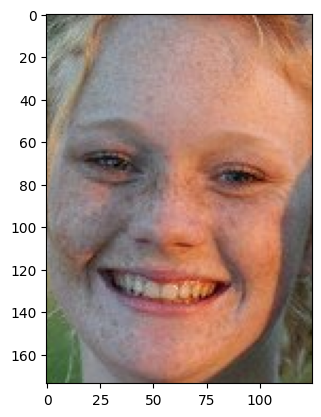

tar img test\target_img\target1.jpg 

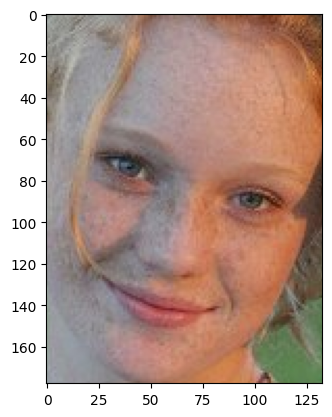

test\masked_girls.jpg vs test\target_img\target1.jpg result: 0.4073473094755905
tar img test\target_img\target1.jpg 

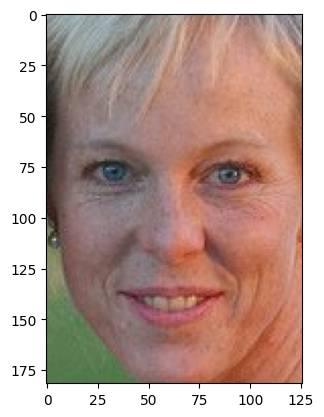

test\masked_girls.jpg vs test\target_img\target1.jpg result: 0.8165848875433646
tar img test\target_img\target2.jpg 

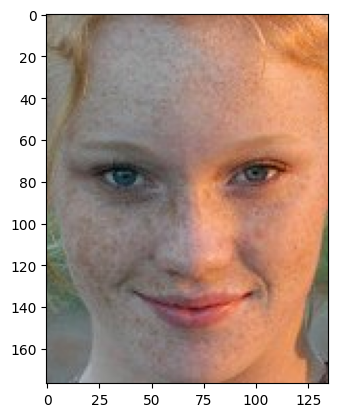

test\masked_girls.jpg vs test\target_img\target2.jpg result: 0.5057462582276985
tar img test\target_img\target2.jpg 

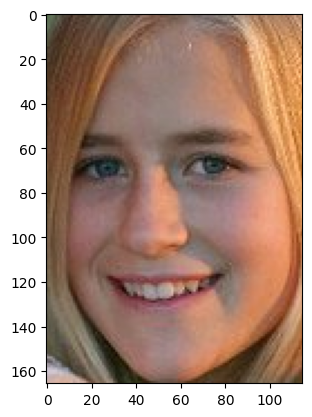

test\masked_girls.jpg vs test\target_img\target2.jpg result: 0.727222534107809
masked_path test\masked_girls.jpg 

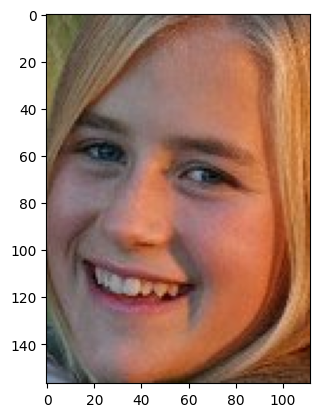

tar img test\target_img\target1.jpg 

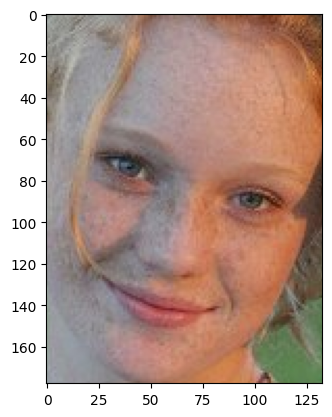

test\masked_girls.jpg vs test\target_img\target1.jpg result: 0.8309512502751439
tar img test\target_img\target1.jpg 

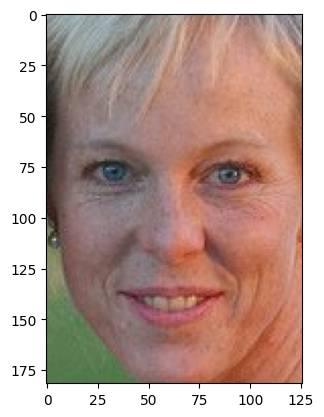

test\masked_girls.jpg vs test\target_img\target1.jpg result: 0.8854584455302408
tar img test\target_img\target2.jpg 

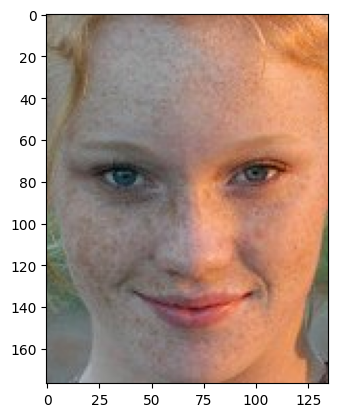

test\masked_girls.jpg vs test\target_img\target2.jpg result: 0.8926051043335841
tar img test\target_img\target2.jpg 

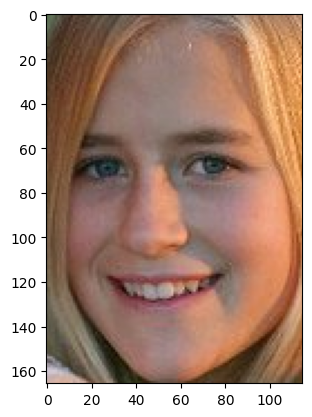

test\masked_girls.jpg vs test\target_img\target2.jpg result: 0.18814712573978587
distance_matrix: [[0.40734731 0.81658489 0.50574626 0.72722253]
 [0.83095125 0.88545845 0.8926051  0.18814713]]
[[['test\\masked_girls.jpg', facial area (x: 189 y: 185 Size: (112,157))], array(['test\\target_img\\target2.jpg',
       facial area (x: 293 y: 177 Size: (115,166))], dtype=object)], [['test\\masked_girls.jpg', facial area (x: 30 y: 101 Size: (125,174))], array(['test\\target_img\\target1.jpg',
       facial area (x: 67 y: 143 Size: (133,178))], dtype=object)]]


In [115]:
# pairs = checker.check_similarity()

# print(pairs)